In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [12]:
import os
import zipfile

# Define paths for the zip file and extraction directory
zip_path = 'devnagari_digit.zip'  # Adjust filename if needed
extract_dir = 'dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


# dataset/DevanagariHandwrittenDigitDataset/Train
# dataset/DevanagariHandwrittenDigitDataset/Test
root_dir = os.path.join(extract_dir, 'DevanagariHandwrittenDigitDataset')
train_dir = os.path.join(root_dir, 'Train')
test_dir = os.path.join(root_dir, 'Test')

# Verify that the directories exist
print(f"Training directory exists: {os.path.exists(train_dir)}")
print(f"Testing directory exists: {os.path.exists(test_dir)}")

Training directory exists: True
Testing directory exists: True


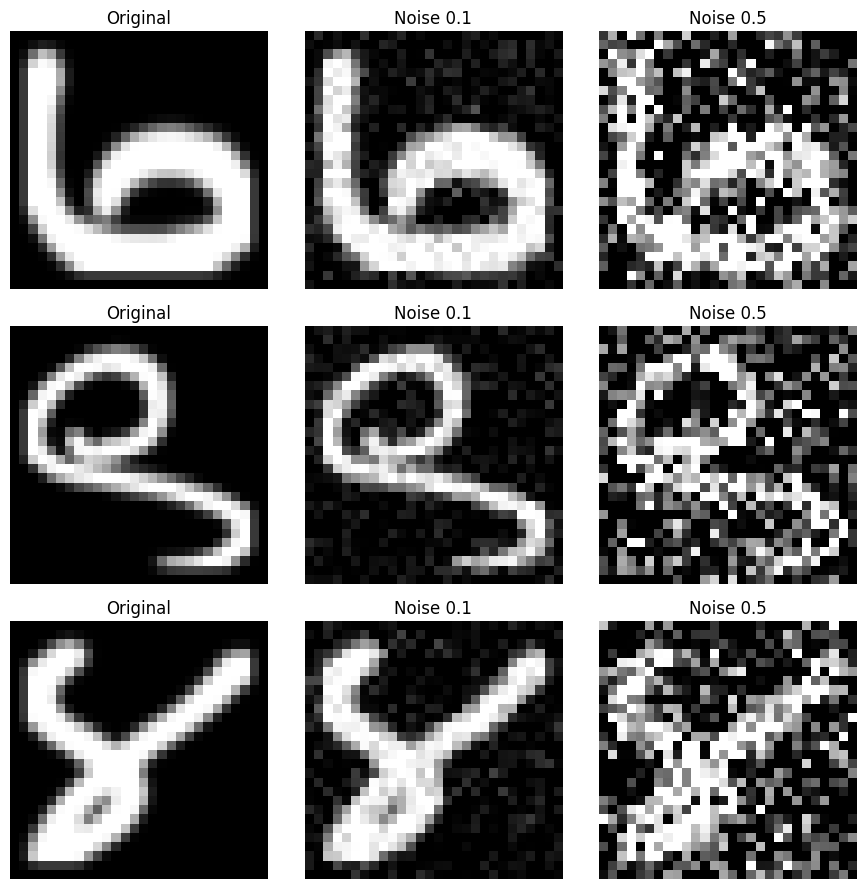

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming the previous code for loading and preprocessing is already run
# (i.e., x_train, x_train_noisy_low, x_train_noisy_high are already defined)

# Define paths (from your previous code)
extract_dir = 'dataset'
root_dir = os.path.join(extract_dir, 'DevanagariHandwrittenDigitDataset')
train_dir = os.path.join(root_dir, 'Train')

# Function to load images from a directory (from your previous code)
def load_images_from_directory(directory, target_size=(28, 28)):
    images = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith('.png') or filename.endswith('.jpg'):
                    img_path = os.path.join(subdir_path, filename)
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(target_size)  # Resize to 28x28
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    images.append(img_array)
    return np.array(images)

# Load training images
x_train = load_images_from_directory(train_dir)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # Reshape for consistency

# Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)

# Select random indices for visualization
n = 3  # Number of images to show
random_indices = np.random.choice(len(x_train), size=n, replace=False)  # Select n random indices

# Visualize in a 3x3 grid with random images
plt.figure(figsize=(9, 9))
for i, idx in enumerate(random_indices):
    # Original image
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Low noise image
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_train_noisy_low[idx].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')
    
    # High noise image
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(x_train_noisy_high[idx].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
def build_encoder(input_shape=(28, 28, 1)):
    """
    Build the encoder part of the convolutional autoencoder.
    Parameters:
        input_shape (tuple): Shape of the input image. Default is (28, 28, 1).
    Returns:
        input_img (Keras Input): Input layer of the model.
        encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    return input_img, encoded


In [27]:
def build_decoder(encoded_input):
    """
    Build the decoder part of the convolutional autoencoder.
    Parameters:
        encoded_input (Keras Tensor): The output from the encoder.
    Returns:
        decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded

In [29]:
def build_autoencoder():
    """
    Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.
    Returns:
        autoencoder (Keras Model): Compiled autoencoder model.
    """
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


In [35]:
# Build and summarize
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:

# Choose one of the noisy datasets for training
x_train_noisy = x_train_noisy_high  

# Split into training and testing sets
from sklearn.model_selection import train_test_split

x_train_noisy, x_test_noisy, x_train_clean, x_test_clean = train_test_split(
    x_train_noisy, x_train, test_size=0.2, random_state=42
)


In [37]:

# Step 3: Train the Autoencoder (Page 12)
history = autoencoder.fit(
    x_train_noisy, x_train_clean,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test_clean)
)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.4626 - val_loss: 0.2301
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.2195 - val_loss: 0.2077
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.2056 - val_loss: 0.2005
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1994 - val_loss: 0.1999
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1968 - val_loss: 0.1942
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.1940 - val_loss: 0.1934
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1918 - val_loss: 0.1909
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1903 - val_loss: 0.1896
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.1890 - val_loss: 0.1889
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.1881 - val_loss: 0.1878


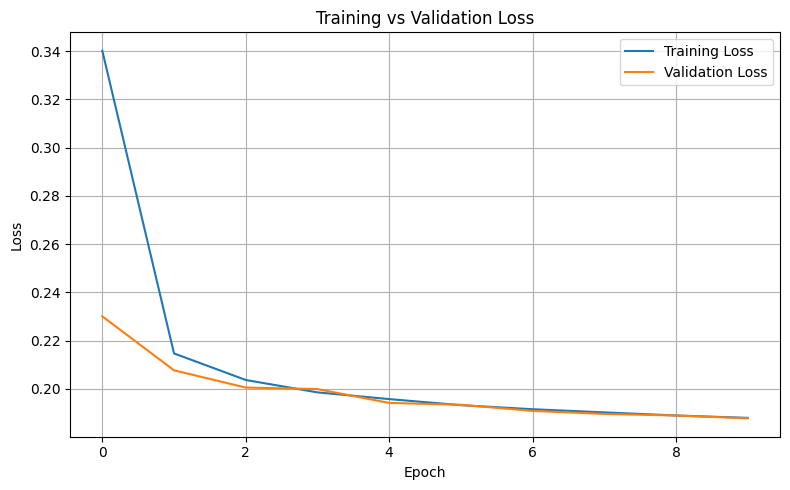

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


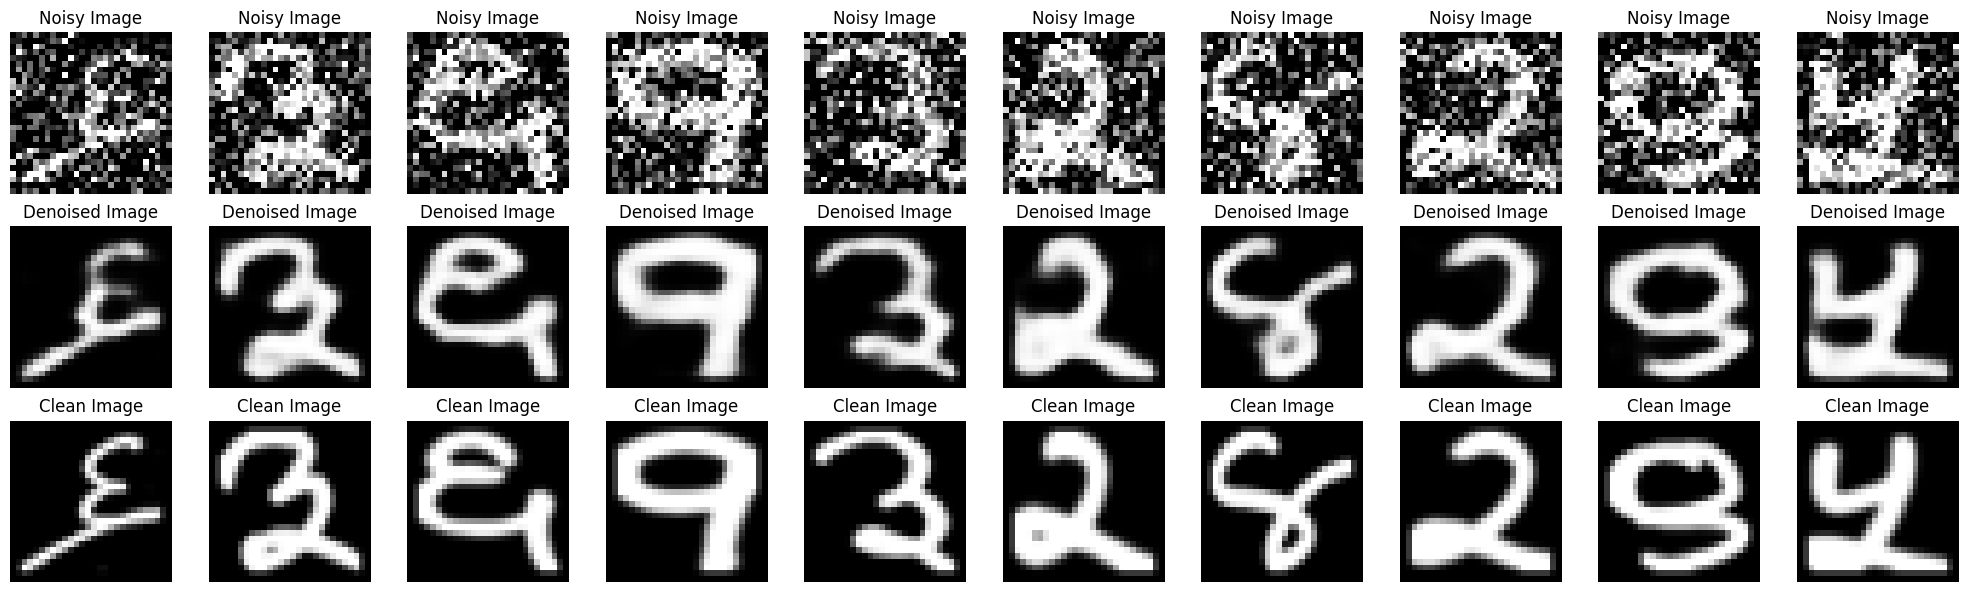

In [40]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy)

# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 10 images
plot_images(x_test_noisy, denoised_images, x_test_clean, n=10)
